<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/L9_Min_batch_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
from torch import nn

In [0]:
#export
def get_data():
  MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
  path=datasets.download_data(MNIST_URL,ext='.gz'); 
  with gzip.open(path,'rb') as f:
    ((x_train, y_train),(x_valid, y_valid),_)=pickle.load(f, encoding='latin-1')
  return map(tensor,(x_train, y_train, x_valid,y_valid))

def normalize(x,m,s): return (x-m)/s

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

In [0]:
mpl.rcParams['image.cmap']='gray'

In [0]:
r,c = x_train.shape
cat=y_train.max()+1
cat=cat.item()
rh=50

In [6]:
r,c,rh,cat

(50000, 784, 50, 10)

In [0]:
class Model(nn.Module):
  def __init__(self,n_in, nh, n_out):
    super().__init__()
    self.layers=[nn.Linear(n_in, nh),nn.ReLU(),nn.Linear(nh,n_out)]
  
  def __call__(self,x):
    for l in self.layers:x=l(x)
    return x


In [0]:
model = Model(c, rh, cat)

In [0]:
for name, l in model.named_children(): print(f'{name}:{l}') 

In [0]:
pred=model(x_train)

In [0]:
pred.shape

torch.Size([50000, 10])

#Cross entropy loss
$$i=\frac{e^{x_i}}{\sum_{j=0}^{n-1}e^{x_j}}$$

In [0]:
def log_softmax(x):
  return (x.exp()/x.exp().sum(-1,keepdim=True)).log()

In [0]:
sm_pred=log_softmax(pred)

In [0]:
def nll(input, target): return -input[range(target.shape[0]),target].mean()

In [0]:
loss=nll(sm_pred, y_train)

In [0]:
loss

tensor(2.2993, grad_fn=<NegBackward>)

In [0]:
def log_softmax(x): return x-x.logsumexp(-1,keepdim=True)

In [0]:
nll(log_softmax(pred),y_train)

tensor(2.2993, grad_fn=<NegBackward>)

In [0]:
nn.functional.nll_loss(nn.functional.log_softmax(pred,-1),y_train)

tensor(2.2992, grad_fn=<NllLossBackward>)

In [0]:
nn.functional.cross_entropy(pred,y_train)

tensor(2.2992, grad_fn=<NllLossBackward>)

**Basic Training Loop**

In [0]:
loss_func=nn.functional.cross_entropy

In [0]:
def accuracy(pred,tg): return (torch.argmax(pred, dim=1)==tg).float().mean()

In [11]:
bs=64
xb=x_train[0:bs]
preds=model(xb)
preds[0], preds.shape

(tensor([ 0.0863, -0.2337, -0.0459, -0.0235,  0.0417,  0.0661,  0.0538,  0.0498,
         -0.0102,  0.0485], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [12]:
yb=y_train[0:bs]
loss_func(preds,yb),accuracy(preds,yb)

(tensor(2.3062, grad_fn=<NllLossBackward>), tensor(0.0625))

In [0]:
lr=0.5
epochs=1

In [0]:
for epoch in range(epochs):
  for i in range(x_train.shape[0]//bs+1):
    start_i = i *bs
    end_i = start_i + bs
    xb = x_train[start_i: end_i]
    yb = y_train[start_i: end_i]
    loss=loss_func(model(xb), yb)
    loss.backward()
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l,'weight'):
          l.weight -= lr*l.weight.grad
          l.bias -= lr * l.bias.grad
          l.weight.grad.zero_()
          l.bias.grad.zero_()



In [15]:
loss, accuracy(model(xb), yb)

(tensor(0.2231, grad_fn=<NllLossBackward>), tensor(0.9375))

**Use nn.Module to refactory the code. get ride of loop that updates the weights with model.parameter()**

In [0]:
class Model(nn.Module):
  def __init__(self, n_in, nh, n_out):
    super().__init__()
    self.l1=nn.Linear(n_in, nh)
    self.l2=nn.Linear(nh, n_out)
  
  def __call__(self, x): return self.l2(nn.functional.relu(self.l1(x)))

In [0]:
model=Model(c,rh, cat)

In [19]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [0]:
def fit (epochs,lr):
  for epoch in range(epochs):
    for i in range(x_train.shape[0]//bs+1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i: end_i]
      yb = y_train[start_i: end_i]
      loss = loss_func(model(xb), yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters(): p-=p.grad * lr
        model.zero_grad()
  

In [0]:
fit (2, 0.5)

In [22]:
loss, accuracy(model(x_train), y_train)

(tensor(0.2819, grad_fn=<NllLossBackward>), tensor(0.9593))

In [0]:
class DummyModule():
  def __init__(self,n_in,nh,n_out):
    self._modules={}
    self.l1=nn.Linear(n_in,nh)
    self.l2=nn.Linear(nh, n_out)

  def __setattr__(self,k,v):
    if not k.startswith('_'): self._modules[k]=v
    super().__setattr__(k,v)
  
  def __repr__(self):
    return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      for p in l.parameters(): yield p

In [0]:
mdl=DummyModule(c,rh,cat)

In [26]:
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [28]:
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

**Use a list of layers, so need to need set layers in the model**

In [0]:
layers=[nn.Linear(c, rh), nn.ReLU(), nn.Linear(rh,cat)]

In [0]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers= layers
    for i, l in enumerate(self.layers): self.add_module(f'layer_{i}',l)  # this is same as if not k.startswith('_'): self._modules[k]=v

  def __call__(self,x):
    for l in self.layers: x= l(x)
    return x


In [0]:
model=Model(layers)

In [38]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

however  '''for i, l in enumerate(self.layers): self.add_module(f'layer_{i}',l) ''' is clunky. nn.ModuleList has this built in

In [0]:
#Modulelist
class SModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers=nn.ModuleList(layers)
  def __call__(self,x):
    for l in self.layers:
      x=l(x)
      return x

In [0]:
model = SModel(layers)

In [42]:
model

SModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

nn.Sequential can replace the whole calss SModel codes

In [0]:
model = nn.Sequential(nn.Linear(c, rh), nn.ReLU(), nn.Linear(rh, cat))

In [0]:
fit(2, 0.5)

In [26]:
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.1216, grad_fn=<NllLossBackward>), tensor(0.9615))

In [27]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

**Still use fit() to train model. Replace that with a class Optimizer()**


  

```
with torch.no_grad():
    for p in model.parameters(): p-=p.grad * lr
      model.zero_grad()
```


      

In [0]:
class Optimizer():
  def __init__(self, parameters, lr=0.5): self.parameters, self.lr=parameters, lr
  def step(self):
    with torch.no_grad(): 
      for p in self.parameters: p-= p.grad*self.lr

  def zero_grad(self):
    for p in self.parameters: p.grad.data.zero_()


In [0]:
opt=Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
  for i in range(x_train.shape[0]//bs+1):
    start_i = i*bs
    end_i = start_i + bs
    xb= x_train[start_i:end_i]
    yb= y_train[start_i:end_i]
    pred=model(xb)
    loss=loss_func(pred,yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

In [31]:
loss_func(model(x_train),y_train), accuracy(model(x_train), y_train)

(tensor(0.1114, grad_fn=<NllLossBackward>), tensor(0.9657))

class Optimizer() can be replaced by torch.optim.SGD()

In [0]:
def get_model():
  model = nn.Sequential(nn.Linear(c, rh), nn.ReLU(), nn.Linear(rh, cat))
  return model, torch.optim.SGD(model.parameters(), lr=0.5)

In [33]:
loss_func(model(x_train), y_train)

tensor(0.1114, grad_fn=<NllLossBackward>)

In [0]:
for epoch in range(epochs):
  for i in range(x_train.shape[0]//bs+1):
    start_i = i*bs
    end_i = start_i+bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()


In [35]:
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.1114, grad_fn=<NllLossBackward>), tensor(0.9657))

Now let us simplify the data part
```
start_i = i*bs
    end_i = start_i+bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)
```

In [0]:
class Dataset():
  def __init__(self,x, y): self.x, self.y= x,y
  def __len__(self):return len(self.x)
  def __getitem__(self, i): return self.x[i], self.y[i]

In [0]:
train_ds = Dataset(x_train, y_train)

In [82]:
len(train_ds)

50000

In [0]:
model, opt = get_model()

In [0]:
for epoch in range(epochs):
  for i in range(x_train.shape[0]//bs+1):
    xb, yb = train_ds[i*bs: (i+1)*bs]
    pred=model(xb)
    loss=loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()

In [40]:
loss_func(model(x_train), y_train), accuracy(model(x_train),y_train)

(tensor(0.1956, grad_fn=<NllLossBackward>), tensor(0.9397))

In [0]:
class Dataloader():
  def __init__(self, ds, bs):
    self.ds, self.bs = ds, bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i: i+self.bs]

In [0]:
train_dl= Dataloader(train_ds,bs)

In [44]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

(<matplotlib.image.AxesImage at 0x7f5a48bbed68>, tensor(5))

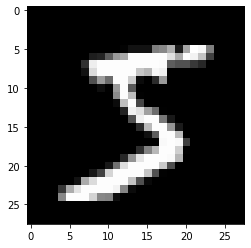

In [95]:
plt.imshow(xb[0].view(28,28)), yb[0]

In [0]:
model, opt = get_model()
def fit():
  for epoch in range (epochs):
    for xb, yb in train_dl: 
      pred= model(xb)
      loss= loss_func(pred, yb)
      loss.backward()
      opt.step()
      opt.zero_grad()

In [0]:
fit()

In [47]:
loss_func(model(x_train), y_train), accuracy(model(x_train),y_train)

(tensor(0.2104, grad_fn=<NllLossBackward>), tensor(0.9355))

Random Sampling 

In [0]:
class Sampler():
  def __init__(self, ds, bs, shuffle=True):
    self.len, self.bs, self.shuffle = len(ds), bs, shuffle
  
  def __iter__(self):
    self.idxs= torch.randperm(self.len) if self.shuffle else torch.arange(self.len)
    for i in range(0, self.len, self.bs): yield self.idxs[i: i+self.bs]


In [0]:
s_ds=Dataset(*train_ds[:10])

In [0]:
s = Sampler(s_ds, 3, True)

In [0]:
t=[o for o in s][0]

In [52]:
t

tensor([0, 6, 2])

In [158]:
[s_ds[i][1] for i in t]

[tensor(9), tensor(5), tensor(4)]

In [0]:
def collate(b):
  xs, ys= zip(*b)
  return torch.stack(xs), torch.stack(ys)

In [0]:
class DataLoader():
  def __init__(self, ds, sampler):# collect_fn=collect
    self.ds, self.sampler = ds, sampler
  
  def __iter__(self):
    for s in self.sampler: yield self.ds[s]

In [0]:
train_ds=Dataset(x_train, y_train)
valid_ds=Dataset(x_valid, y_valid)

In [0]:
train_samp= Sampler(train_ds, bs)
valid_samp= Sampler(valid_ds, bs)

In [0]:
train_dl = DataLoader(train_ds, train_samp)
valid_dl = DataLoader(valid_ds, valid_samp)

In [0]:
xb, yb = next(iter(train_dl))

(<matplotlib.image.AxesImage at 0x7f5a48aa7550>, tensor(0))

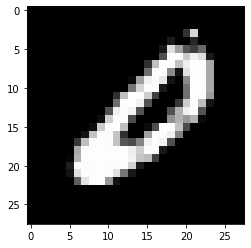

In [172]:
plt.imshow(xb[0].view(28,28)), yb[0]

Pytorch DataLoader

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
train_dl = DataLoader(train_ds, bs, sampler= RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [62]:
model, opt = get_model()
fit()
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.2301, grad_fn=<NllLossBackward>), tensor(0.9267))

In [0]:
class Runner():
  def __init__(self, model, train_dl, valid_dl, bs, opt):
    self.model=model
    self.train_dl=train_dl
    self.valid_dl=valid_dl
    self.bs=bs
    self.opt=opt
  def fit(self, epochs, lr):
    for epoch in range(epochs):
      model.train()
      for xb, yb in train_dl:
        loss=loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
      model.eval()
      with torch.no_grad():
        tot_loss, tot_acc=0.,0.
        for xb, yb in valid_dl:
          tot_loss +=loss_func(model(xb),yb)
          tot_acc += accuracy(model(xb),yb)
      nv = len(valid_dl)
      print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
model, opt = get_model()
run = Runner(model, train_dl, valid_dl,bs, opt)

In [90]:
run.fit(5,0.1)

0 tensor(0.1958) tensor(0.9416)
1 tensor(0.1213) tensor(0.9626)
2 tensor(0.1634) tensor(0.9531)
3 tensor(0.1024) tensor(0.9699)
4 tensor(0.0990) tensor(0.9715)


(tensor(0.0990), tensor(0.9715))